# Final CHO Model
This notebook is to asses the validity of our reconstruction and how complete it is.

[1. Generation of the dataset and model reconstruction](#generation) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.1 Retrieve information from the Google Sheet datasets reactions and metabolites**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.2 Build a model and feed it the information from the df generated** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.3 Save and validate the model** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**1.4 Check for unbalanced reactions** <br>

[2. Identification of Blocked Reactions and Dead-End Metabolites](#blocked&deadends) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.1 Identification of Blocked Reactions**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.2 Identification of Dead-Ends Metabolites** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**2.3 Addition of Extracellular Exchange Reanctions** <br>

[3. Generation of the Mass Flow Graph](#MFG) <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.1 Generation of the "D-Matrix"**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.2 Plotting the "D-Matrix", Normalized Flow Graph (NFG)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.3 Generation of the "FluxOpenValue" matrix** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.4 Generation of the "Mass Flow Graph (MFG) Matrix"** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**3.5 Plotting the "MFG Matrix"** <br>

[4. Biomass Conecting Reactions](#biomass) <br>

## 1. Generation of the dataset and model reconstruction <a id='generation'></a>
Here we generate the CHO model from the dataset stored in the Google Sheet file. We first use the google_sheet module to extract all the necessary information from the original dataset. Then we use those dataset and the COBRApy library to: (1) Create a new model and add reactions from the **Rxns Sheet**, (2) Add information on each reaction obtained from the **Rxns Sheet** and **Attributes Sheet**, (3) Add boundary reactions from the **BoundaryRxns Sheet**, and (4) Add information for each metabolite from the **Metabolites Sheet**. Finally we save the model as a SBML file and validate it using the cobrapy built-in function "validate_sbml_model( )".

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime

import cobra
from cobra import Model, Reaction, Metabolite
from cobra.io import validate_sbml_model, save_json_model, write_sbml_model, save_matlab_model, load_matlab_model

from tqdm.notebook import tqdm

from google_sheet import GoogleSheet

### 1.1 Retrieve information from the Google Sheet datasets reactions and metabolites

In [ ]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_met = 'Metabolites'
sheet_rxns = 'Rxns'
sheet_attributes = 'Attributes'
sheet_boundary = 'BoundaryRxns'

metabolites = sheet.read_google_sheet(sheet_met)
rxns = sheet.read_google_sheet(sheet_rxns)
rxns_attributes = sheet.read_google_sheet(sheet_attributes)
boundary_rxns = sheet.read_google_sheet(sheet_boundary)

### 1.2 Build a model and feed it the information from the df generated

In [ ]:
##### ----- Create a model and add reactions ----- #####
model = Model("iCHO")
lr = []
for _, row in rxns.iterrows():
    r = Reaction(row['Reaction'])
    lr.append(r)    
model.add_reactions(lr)

In [ ]:
##### ----- Add information to each one of the reactions ----- #####
for i,r in enumerate(tqdm(model.reactions)):    
    r.build_reaction_from_string(rxns['Reaction Formula'][i])
    r.name = rxns['Reaction Name'][i]
    r.subsystem = rxns['Subsystem'][i]
    r.gene_reaction_rule = str(rxns['GPR_final'][i])
    r.lower_bound = float(rxns_attributes['Lower bound'][i])
    r.upper_bound = float(rxns_attributes['Upper bound'][i])

In [ ]:
##### ----- Add Boundary Reactions ----- #####
dr = []
for _, row in boundary_rxns.iterrows():
    r = Reaction(row['Reaction'])
    dr.append(r)    
model.add_reactions(dr)

boundary_rxns_dict = boundary_rxns.set_index('Reaction').to_dict()
boundary_rxns_dict

for i,r in enumerate(tqdm(model.reactions)):
    if r in dr:
        r.build_reaction_from_string(boundary_rxns_dict['Reaction Formula'][r.id])
        r.name = boundary_rxns_dict['Reaction Name'][r.id]
        r.subsystem = boundary_rxns_dict['Subsystem'][r.id]
        r.lower_bound = float(boundary_rxns_dict['Lower bound'][r.id])
        r.upper_bound = float(boundary_rxns_dict['Upper bound'][r.id]) 
model

In [ ]:
##### ----- Add information for each metabolite ----- #####
metabolites_dict = metabolites.set_index('BiGG ID').to_dict('dict')
metabolites_dict['Name']
for met in model.metabolites:
    met.name = metabolites_dict['Name'][f'{met}']
    met.formula = metabolites_dict['Formula'][f'{met}']
    met.compartment = metabolites_dict['Compartment'][f'{met}'].split(' - ')[0]
    try:
        met.charge = int(metabolites_dict['Charge'][f'{met}'])
    except (ValueError, TypeError):
        print(f'{met} doesnt have charge')

### 1.3 Save and validate the model

In [ ]:
##### ----- Build the S matrix ----- #####
S = cobra.util.create_stoichiometric_matrix(model, array_type='dense')
model.S = S

model.solver = 'gurobi'
model.objective = 'biomass_cho'
sol = model.optimize()
sol

In [ ]:
c=0
for f in sol.fluxes:
    if f != 0:
        c+=1
        
print(c)

In [ ]:
##### ----- Save the model ----- #####

# XML
model_name_xml = 'iCHOv3_CHO_'+datetime.now().strftime("%d%m%Y")+'.xml' 
write_sbml_model(model, model_name_xml)

# JSON, because the sbml doesnt save the subsystems
model_name_json = 'iCHOv3_CHO_'+datetime.now().strftime("%d%m%Y")+'.json' 
save_json_model(model, model_name_json)

# MATLAB
model_name_matlab = 'iCHOv3_CHO_'+datetime.now().strftime("%d%m%Y")+'.mat' 
save_matlab_model(model, model_name_matlab)

In [ ]:
##### ----- Test for errors in the recostruction ----- ######

# import tempfile
# from pprint import pprint
# from cobra.io import write_sbml_model, validate_sbml_model
# with tempfile.NamedTemporaryFile(suffix='.xml') as f_sbml:
#     write_sbml_model(model, filename=f_sbml.name)
#     report = validate_sbml_model(filename=f_sbml.name)
# pprint(report)

from cobra.io import read_sbml_model, validate_sbml_model
(_, errors) = validate_sbml_model(model_name_xml)
errors

### 1.4 Check for unbalanced reactions
Once the model is checked and saved as a xml and json format we then evaluate the amount of mass and charge unbalanced reactions

In [ ]:
# Check for unbalanced reactions
subsystems = ['BIOMASS SYNTHESIS', 'PROTEIN ASSEMBLY', 'PROTEIN DEGRADATION'] # filter out the reactions from these subsystems

# Lists to store the data for each column
reaction_ids = []
formulas = []
metabolites = []
unbalances = []

counter = 0
for rxn in model.reactions:
    if not rxn.id.startswith(('EX_','DM_','SK_')) and rxn.subsystem not in subsystems:
        mb = rxn.check_mass_balance()
        if mb != {}:# and set(mb.keys()) != {'charge'}:  # Check if dictionary has keys other than 'charge'
            counter+=1
            prod_ids = [{met.id:met.formula} for met in rxn.products]
            react_ids = [{met.id:met.formula} for met in rxn.reactants]
            # Append values to lists
            print(rxn.id)
            reaction_ids.append(rxn.id)
            print(rxn.reaction)
            formulas.append(rxn.reaction)
            print(react_ids + prod_ids)
            metabolites.append(react_ids + prod_ids)
            print(mb)
            unbalances.append(mb)
            print('...............................')
print(counter)

# Create DataFrame from lists
mass_unbalanced_reactions = pd.DataFrame({
    "Reaction ID": reaction_ids,
    "Formula": formulas,
    "Metabolites": metabolites,
    "Unbalance": unbalances
})

mass_unbalanced_reactions.to_excel("temp/mass_unbalanced_reactions.xlsx", engine='openpyxl', index=False)

In [ ]:
# Update the "Balance status" column based on whether the reaction is present in "reaction_ids"
rxns_copy = rxns.copy()
rxns_copy['Balance status'] = rxns_copy['Reaction'].apply(lambda x: 'UNBALANCED' if x in reaction_ids else 'BALANCED')
rxns_equals = rxns_copy.equals(rxns)

In [ ]:
##############################################
#### ------------------------------------ ####
#### ---- Update Rxns Google Sheets ----- ####
#### ------------------------------------ ####
##############################################
if not rxns_equals:
    sheet.update_google_sheet(sheet_rxns, rxns_copy)
    print("Google Sheet updated.")

## 2. Identification of Blocked Reactions and Dead-End Metabolites <a id='blocked&deadends'></a>
In this second part of the notebook we use two different functions from the utils module to: (1) Run a flux variability analysis and identify blocked reactions, and (2) identify dead-end metabolites. Finally we add Extracellular Exchange reactions for the dead-end metabolites that are in the extracellular compartment.

In [ ]:
import pandas as pd
from cobra.io import load_json_model
from cobra.flux_analysis import find_blocked_reactions, flux_variability_analysis
from utils import detect_dead_ends

In [ ]:
##### ----- Read Model ----- #####
if 'model' not in locals():
    model = load_json_model("iCHOv3_CHO_04032024.json")
    print('Model loaded')
else:
    print('Model already generated')

### 2.1 Identification of Blocked Reactions
Here we use the COBRApy built-in functions **find_blocked_reactions** and **flux_variability_analysis** to find blocked reactions in our reconstruction and run an FVA analysis respectively.

In [ ]:
##### ----- Blocked Reactions ----- #####
for rxn in model.boundary:
    if rxn.id.startswith("EX_"):
        rxn.bounds = (-1000,1000)
    if rxn.id.startswith("SK_"):
        rxn.bounds = (-1000,1000)
    if rxn.id.startswith("DM_"):
        rxn.bounds = (0,1000)

model.solver = 'gurobi'
blocked_reactions = find_blocked_reactions(model)

In [ ]:
blocked_reactions

In [ ]:
### ---- FVA ---- ####
model.solver = 'gurobi'
fva_results = flux_variability_analysis(model)
fva_results.to_excel('temp/fva_results.xlsx')

In [ ]:
## Check if any reactions in the BIOMASS subsystem is blocked
for rxn in blocked_reactions:
    r = model.reactions.get_by_id(rxn)
    if r.subsystem == 'BIOMASS':
        print(r.id)
        print('-----------------')
        print('-----------------')
        for met in r.metabolites:
            m = model.metabolites.get_by_id(met.id)
            print(m)
            print('.................')
            for r2 in m.reactions:
                if r2.id in blocked_reactions:
                    print(f'No Flux -> {r2.id}: {r2.reaction}')
                else:
                    print(f'With Flux -> {r2.id}: {r2.reaction}')
            print('.................')
            print(' ')
                

In [ ]:
##### ----- Print the amount  and % of blocked reactions ----- #####
print('##### ----- Blocked Reactions ----- #####')
print(f'The model has {len(model.reactions)} total reactions')
print(f'The model has {len(blocked_reactions)} ({round(len(blocked_reactions)/len(model.reactions)*100)}%) blocked reactions')

### 2.2 Identification of Dead-Ends Metabolites
The detect_dead_ends( ) function from the utils module returns a list with all the **dead-end** metabolites in our model. A dead-end metabolite refers to a metabolite that is either only consumed but not produced, or only produced but not consumed, in a given metabolic network. The results are stored in the "Dead-ends.txt" file.

In [ ]:
##### ----- Detect Dead-Ends ----- #####
model.solver = 'gurobi' #change 'gurobi' for the default cobrapy solver 'glpk' 
dead_ends = detect_dead_ends(model)

In [ ]:
counter=0
for i, is_dead_end in enumerate(dead_ends):
    if is_dead_end:
        metabolite = model.metabolites[i]
        print(metabolite)
        counter+=1
        
print(counter)

In [ ]:
# Save dead ends and their associated reaction in a pandas df
data = []

for i, is_dead_end in enumerate(dead_ends):
    if is_dead_end:
        metabolite = model.metabolites[i]
        reactions = [str(met_rxn) for met_rxn in metabolite.reactions]  # Convert reactions to strings
        data.append([metabolite.id] + reactions)

# Convert the list to a DataFrame
dead_ends_df = pd.DataFrame(data, columns=['Metabolite', 'Reaction1', 'Reaction2', 'Reaction3', 'Reaction4'])  # 'etc.' is a placeholder

# Adjusting the DataFrame to handle variable number of reactions
dead_ends_df = dead_ends_df.apply(lambda x: pd.Series(x.dropna().values), axis=1).fillna('')

# Renaming the columns appropriately
new_columns = ['Metabolite'] + [f'Reaction{i}' for i in range(1, len(dead_ends_df.columns))]
dead_ends_df.columns = new_columns

dead_ends_df.to_excel('temp/dead_ends_reactions.xlsx', index=False)

print(f'Total amount of dead-end metabolites: {len(dead_ends_df)}')  # To display the first few rows of the DataFrame

In [ ]:
##### --- Create transport reactions to fill the gaps --- ######

def check_metabolite_sides(reactions, metabolite_base):
    sides = []  # List to store the side ('left' or 'right') of each reaction
    for reaction in reactions:
        # Splitting the reaction string into reactants and products
        if '-->' in reaction:
            reactants, products = reaction.split('-->')
        elif '<=>' in reaction:
            reactants, products = reaction.split('<=>')

        # Splitting reactants and products into individual metabolites and trimming whitespace
        reactant_ids = [r.strip() for r in reactants.split('+')]
        product_ids = [p.strip() for p in products.split('+')]

        # Constructing specific identifiers for comparison
        metabolite_id_with_compartment = f"{metabolite_base}_"

        # Checking if the specific identifier is in reactants or products
        if any(metabolite_id_with_compartment in r for r in reactant_ids):
            sides.append('left')
        if any(metabolite_id_with_compartment in p for p in product_ids):
            sides.append('right')

    return 'left' in sides and 'right' in sides


# Use the modified metabolites_compartments dictionary creation logic from before

# Initialize a dictionary to keep track of metabolites, their compartments, and reactions
metabolites_compartments = {}

for i, is_dead_end in enumerate(dead_ends):
    if is_dead_end:
        met = model.metabolites[i]
        base_id = met.id[:-2]  # Extract the base ID of the metabolite
        compartment = met.id[-1]  # Extract the compartment
        reactions = {str(met_rxn) for met_rxn in met.reactions}  # Use a set for unique reactions

        # Check if the base ID is already in the dictionary
        if base_id in metabolites_compartments:
            # Add the compartment if not already present and update the reactions set
            metabolites_compartments[base_id]['compartments'].add(compartment)
            metabolites_compartments[base_id]['reactions'].update(reactions)
        else:
            # If the base ID is not in the dictionary, add it with the current compartment and reactions
            metabolites_compartments[base_id] = {'compartments': {compartment}, 'reactions': reactions}

# Filtering metabolites present on opposite sides of reaction formulas
for metabolite, info in list(metabolites_compartments.items()):
    if len(info['compartments']) > 1:
        # Only keep metabolites that appear on opposite sides of the reaction equations
        if not check_metabolite_sides(info['reactions'], metabolite):
            del metabolites_compartments[metabolite]  # Remove metabolites not meeting the criteria

# Displaying the filtered results
counter=0
transport_reactions = []
for metabolite, info in metabolites_compartments.items():
    if len(info['compartments']) > 1:
        compartments = list(info['compartments'])
        for i in range(len(compartments)):
            for j in range(i+1, len(compartments)):
                # Construct the reaction string
                treaction = f"{metabolite}_{compartments[i]} <=> {metabolite}_{compartments[j]}"
                transport_reactions.append(treaction)
        print(f"{metabolite} is present in compartments: {', '.join(info['compartments'])}")
        print("Associated reactions:")
        for reaction in info['reactions']:
            print(reaction)
        print('------------------------------')
        print(f'Reaction created: {treaction}')
        counter+=1
        print()
print(counter)

In [ ]:
###### --- Exctracting boundary reaction from other recosntructions --- ######

# 1-Create a for loop to check if the metabolite is also present in other reconstruction/
# 2- Check if that metabolite has a Demand/Sink/Exchange reaction in that model.
# 3- Extact that reaction and add it to a excel file.

### 2.3 Addition of Extracellular Exchange Reanctions
The following cell adds **EXTRACELLULAR EXCHANGE** reactions to the dead-end metabolites in the extracellular compartment from the list generated above.

In [ ]:
##### ----- Automatically add EXTRACELLULAR EXCHANGE reactions to the "BoundaryRxns" Sheet ----- #####
added_exchange = False
for i,j in enumerate(dead_ends):
    if j:
        if str(model.metabolites[i]).endswith('_e'):
            new_row_data = {'Curated': '', 'Reaction': 'EX_'+str(model.metabolites[i]), 'Reaction Name': 'Exchange of '+model.metabolites[i].name, 'Reaction Formula': str(model.metabolites[i])+' <=>', 'Subsystem': 'EXTRACELLULAR EXCHANGE',
                                    'Reversible': 1, 'Lower bound': -1000, 'Upper bound': 1000, 'Objective': 0}
            new_row_df = pd.DataFrame(new_row_data, index=[len(boundary_rxns)])
            boundary_rxns = pd.concat([boundary_rxns, new_row_df])
            added_exchange = True

#Check for duplicated reactions added to the boundary_rxns dataset, IF NOT: update the google sheet file
if added_exchange:
    if not boundary_rxns['Reaction'].duplicated().any() and not boundary_rxns['Reaction Formula'].duplicated().any():
        sheet.update_google_sheet(sheet_boundary, boundary_rxns)
        print("BoundaryRxns Google Sheet updated.")
    else:
        print('Duplicated values found in the dataset')

### 2.4 Gapfill for blocked reactions
Cobrapy has a gap filling implementation that is very similar to that of Reed et al. where we use a mixed-integer linear program to figure out the smallest number of reactions that need to be added for a user-defined collection of reactions, i.e. a universal model.

In [ ]:
import cobra
from cobra.flux_analysis import gapfill

#recon_3d = read_sbml_model("../Data/GPR_curation/Recon3D.xml")
#iCHO2291 = read_sbml_model("../Data/Reconciliation/models/iCHO2291.xml")
#universal = recon_3d.merge(iCHO2291)

In [ ]:
for blocked_reaction in blocked:
    model.objective = blocked_reaction
    model.optimize().objective_value
    try:
        solution = gapfill(model, iCHO2291, demand_reactions=True)
        print(blocked_reaction)
        print(solution)
    except Exception as e:
        print(f'Gapfill failed for {blocked_reaction}: {str(e)}')
        continue

### Test CHO - Recon GEM

In [ ]:
universal

In [ ]:
# iCHO_recon3dfrom cobra.io import read_sbml_model
# read_sbml_model(".xml")

model_EX = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
model_SK = [i for i, rxn in enumerate(model.reactions) if 'SK_' in rxn.id]
model_DM = [i for i, rxn in enumerate(model.reactions) if 'DM_' in rxn.id]
for i in model_EX:
    model.reactions[i].bounds = -1000, 1000

for i in model_SK:
    model.reactions[i].bounds = -1000, 1000

for i in model_DM:
    model.reactions[i].bounds = 0, 1000
    

In [ ]:
model.objective = "biomass_cho" # 
sol1 = model.optimize()
print(sol1.objective_value)

model.objective = "biomass_cho_prod" # 
sol2 = model.optimize()
print(sol2.objective_value)

In [ ]:
##### ----- Test model KOs ----- #####
for reaction in model.reactions:
    with model as model:
        reaction.knock_out()
        model.optimize()
        print('%s blocked (bounds: %s), new growth rate %f' %
              (reaction.id, str(reaction.bounds), model.objective.value))

## 3. Generation of the Mass Flow Graph <a id='MFG'></a>
Based on the publication **_Flux-dependent graphs for metabolic networks_** by _Beguerisse-Diaz et al. (2018)_ (https://www.nature.com/articles/s41540-018-0067-y). Here we use our model to build the **D Matrix** and plot the corresponding graph, then the **M Matrix** and plot the corresponding graph, and finally we generate the **PageRank** file with all the reactions in our reconstruction sorted by importance.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy.linalg import pinv
from scipy.sparse import csr_matrix

import time

from skimage import draw
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import cobra
from cobra.io import load_json_model

In [2]:
##### ----- Read Model ----- #####
if 'model' not in locals():
    model = load_json_model("iCHOv3_CHO_05032024.json")
    print('model loaded')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
model loaded


### 3.1 Generation of the "D-Matrix"
The "D-Matrix" defines the weight of the edge between reaction nodes Ri and Rj as the probability that any metabolite chosen at random is produced by Ri (reaction i) and consumed by Rj (reaction j). Summing over all metabolites and normalizing, we obtain the edge weights of the adjacency matrix of the NFG:

In [3]:
# Extract stoichiometric matrix, m=reactions, n=metabolites
start = time.time()
S = cobra.util.array.create_stoichiometric_matrix(model)
n, m = S.shape
end = time.time()
print(f"Time taken to generate S, n and m: {end - start} seconds")

# Create S2m matrix
start = time.time()
r = np.array([reaction.reversibility for reaction in model.reactions]) # m-dimensional reversibility vector with components rj = 1 if reaction Rj is reversible and rj = 0 if it is irreversible.
Im = np.eye(m) # m × m identity matrix
S2m = np.hstack((S, - S * r)) # unfolded version of the stoichiometric matrix of the 2m forward and reverse reactions.
end = time.time()
print(f"Time taken to generate S2m: {end - start} seconds")

# Create S2mplus and S2mminus matrices
start = time.time()
S2mplus = (np.abs(S2m) + S2m) / 2 # production stoichiometric matrix
S2mminus = (np.abs(S2m) - S2m) / 2 # consumption stoichiometric matrix
end = time.time()
print(f"Time taken to generate S2mplus and S2minus: {end - start} seconds")

# Calculate weights
start = time.time()
Wplus = np.diag(np.nan_to_num(1/ np.sum(S2mplus, axis = 1)))
Wminus = np.diag(np.nan_to_num(1 / np.sum(S2mminus, axis = 1)))
end = time.time()
print(f"Time taken to generate Wplus and Wminus: {end - start} seconds")

# Calculate D matrix
start = time.time()
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)
end = time.time()
print(f"Time taken to generate the D-Matrix: {end - start} seconds")
'''
# Remove unused reactions
start = time.time()
IDr = np.nonzero(np.sum(abs(D), axis=0) + np.sum(abs(D), axis=1) == 0)[0]
#IDr = ( np.sum(abs(D), axis=0) + np.sum(abs(D), axis=1) ) == 0
IDr = IDr[IDr > m]

D = np.delete(D, IDr, axis=0)
D = np.delete(D, IDr, axis=1)
end = time.time()
print(f"Time taken to remove unused reactions from the D-Matrix: {end - start} seconds")
'''

Time taken to generate S, n and m: 0.08107709884643555 seconds
Time taken to generate S2m: 0.7934451103210449 seconds
Time taken to generate S2mplus and S2minus: 2.0017151832580566 seconds


/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_7359/215176075.py:25: RuntimeWarning: divide by zero encountered in divide
  Wplus = np.diag(np.nan_to_num(1/ np.sum(S2mplus, axis = 1)))
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_7359/215176075.py:26: RuntimeWarning: divide by zero encountered in divide
  Wminus = np.diag(np.nan_to_num(1 / np.sum(S2mminus, axis = 1)))


Time taken to generate Wplus and Wminus: 0.4083840847015381 seconds
Time taken to generate the D-Matrix: 176.0327181816101 seconds


'\n# Remove unused reactions\nstart = time.time()\nIDr = np.nonzero(np.sum(abs(D), axis=0) + np.sum(abs(D), axis=1) == 0)[0]\n#IDr = ( np.sum(abs(D), axis=0) + np.sum(abs(D), axis=1) ) == 0\nIDr = IDr[IDr > m]\n\nD = np.delete(D, IDr, axis=0)\nD = np.delete(D, IDr, axis=1)\nend = time.time()\nprint(f"Time taken to remove unused reactions from the D-Matrix: {end - start} seconds")\n'

### 3.2 Plotting the "D-Matrix", Normalized Flow Graph (NFG)
The NFG is a weighted, directed graph with reactions as nodes, the edges represent supplier-consumer relationships between reactions, and weights given by the probability that a metabolite chosen at random from all reactions is produced/consumed by the source/target reaction (this discounts naturally the over-representation of pool metabolites). The edge indicates that metabolites are produced by the source reaction and consumed by the target reaction, thus accounting for metabolic directionality.

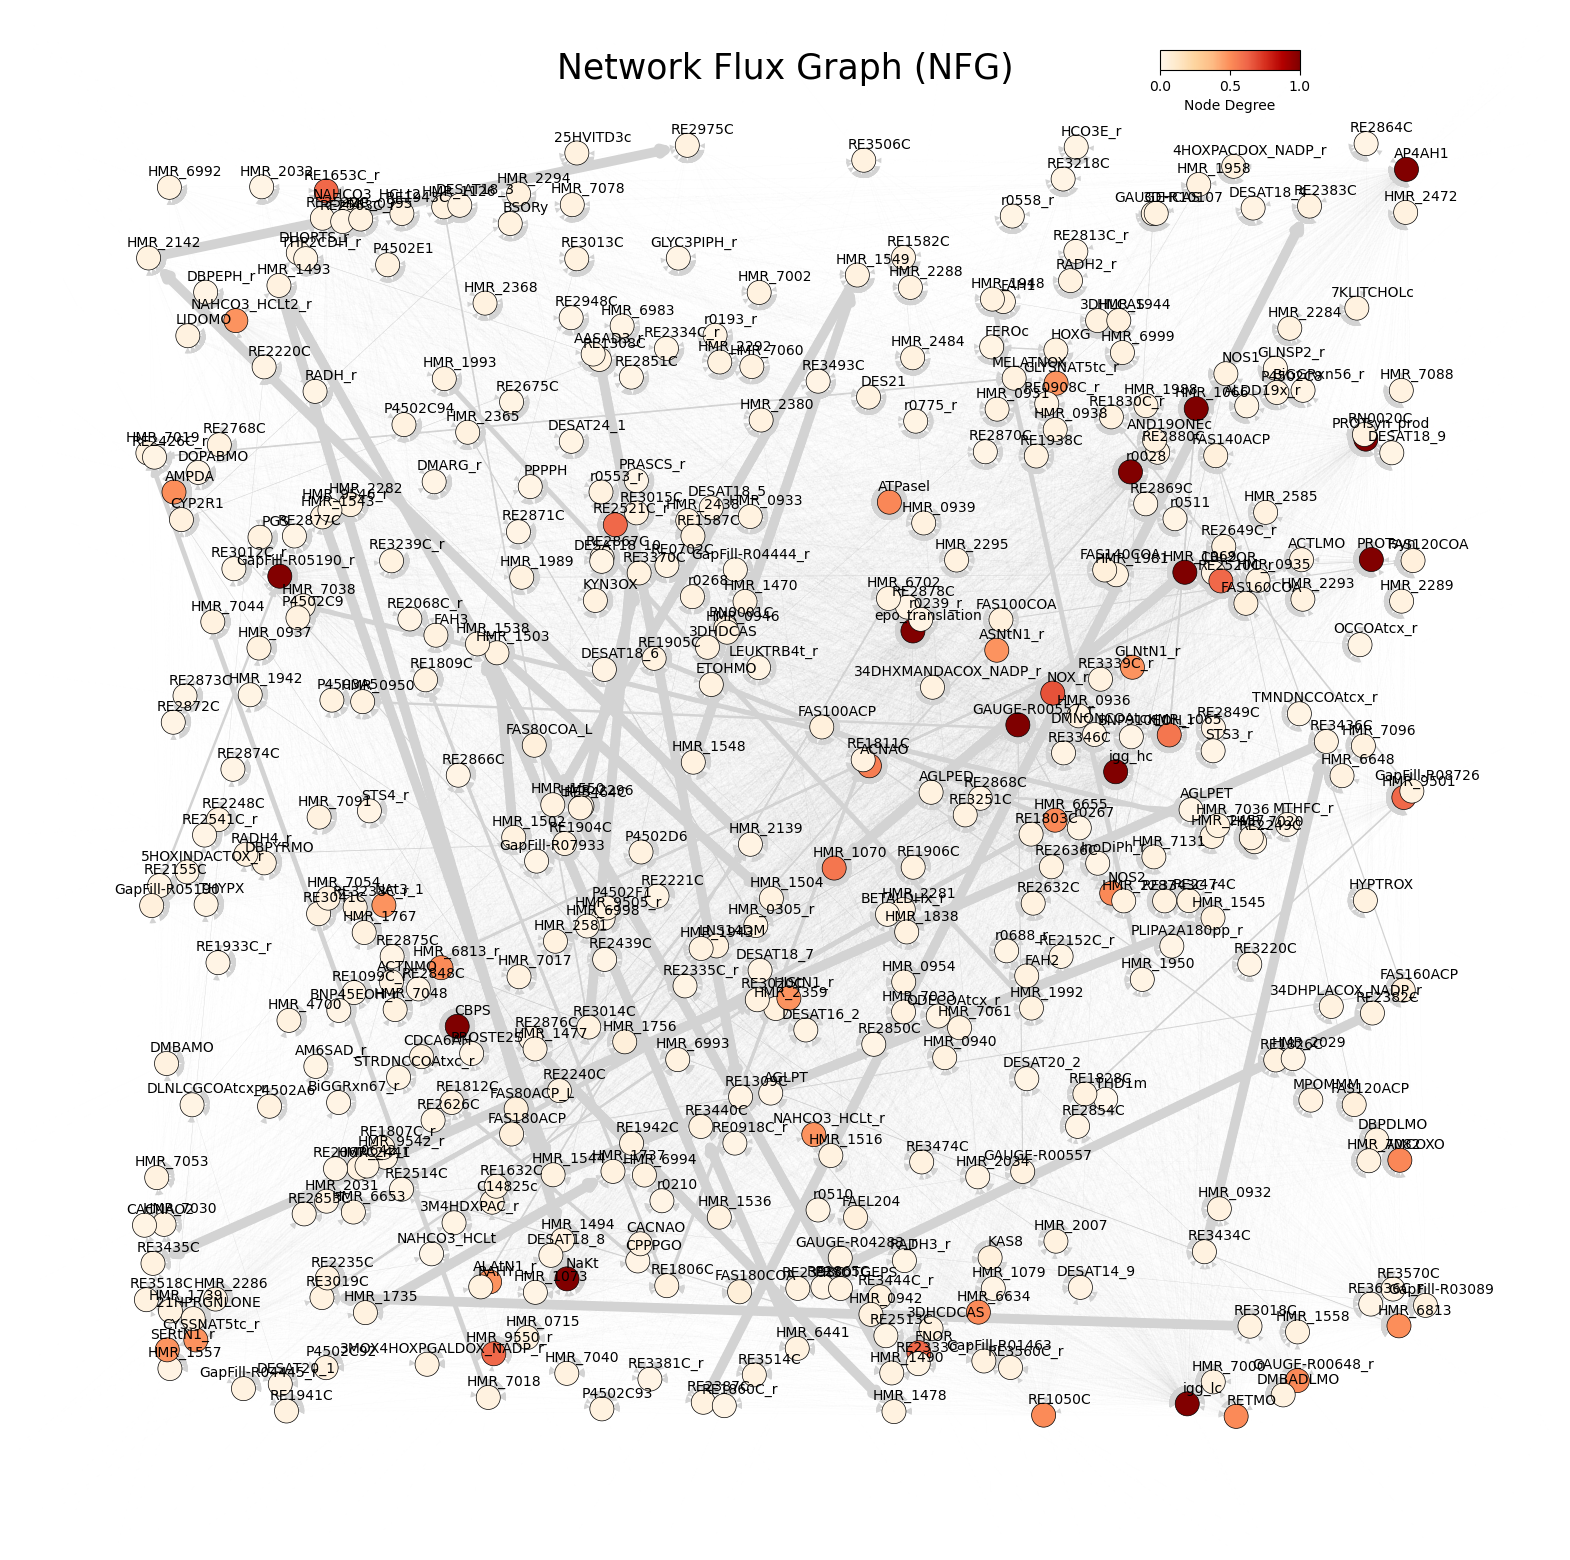

In [4]:
# -------------------
# NetworkX Processing
# -------------------


# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 2500 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions], 
                                 [reaction.id + '_r' for reaction in model.reactions]))
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.random_layout(G_filtered)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Network Flux Graph (NFG)', fontsize=25, y=0.95)

# Labels
label_pos_filtered = {node: (x + 0.012, y + 0.012) for node, (x, y) in pos_filtered.items()}
nx.draw_networkx_labels(G_filtered, label_pos_filtered, labels=node_labels_filtered, font_size=10, ax=ax)

# Add a colorbar as the legend for node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
sm.set_array([])
cbar_ax = fig.add_axes([0.7, 0.85, 0.07, 0.01])
cbar = plt.colorbar(sm, cax=cbar_ax, label='Node Degree', orientation='horizontal')

plt.savefig('../Networks/normalized_flow_graph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [5]:
elements = []

# Add nodes with positions to elements list
for node, pos in pos_filtered.items():
    elements.append({
        'data': {'id': str(node), 'label': node_labels_filtered[node]},
        'position': {'x': pos[0]*1000, 'y': pos[1]*1000}  # Multiplying to scale up positions
    })

# Add edges to elements list
for u, v in G_filtered.edges():
    elements.append({
        'data': {'id': f'{u}-{v}', 'source': str(u), 'target': str(v)}
    })

In [6]:
# Revised code snippet to append styles for edges with corrected indexing

# Reset or define your stylesheet list if not already done
stylesheet = [
    # Node style can be defined here
    {
        'selector': 'node',
        'style': {
            'background-color': 'black', 
            'label': 'data(label)',
            'color': 'white',
            'border-color': 'black',
            'border-width': 2,
        }
    },
]

# Directly iterate over edges to avoid indexing issues
edge_counter = 0  # Separate counter for edge indexing in normalized_weights
for edge in elements:
    if 'source' in edge['data']:  # Ensure we're dealing with an edge
        width = normalized_weights[edge_counter]  # Use the edge-specific counter
        edge_id = edge['data']['id']
        stylesheet.append({
            'selector': f'edge[id = "{edge_id}"]',
            'style': {
                'width': width,
            }
        })
        edge_counter += 1  # Increment the counter for each edge


In [7]:
import matplotlib.colors as mcolors
# Convert normalized degrees to RGBA colors with the colormap
rgba_colors = [cmap(deg) for deg in normalized_degrees_filtered]

# Convert RGBA to hexadecimal
hex_colors = [mcolors.to_hex(color) for color in rgba_colors]

In [14]:
from dash import Dash, html
import dash_cytoscape as cyto

stylesheet=[
    # Style for nodes
    {
        'selector': 'node',
        'style': {
            'background-color': 'black',  # Nodes color set to black
            'label': 'data(label)',
            'color': 'black',  # Label color set to white for contrast
            'border-color': 'black',
            'border-width': 1,
        }
    },
    # Style for edges
    {
        'selector': 'edge',
        'style': {
            'width': 1,  # Edges are made thinner
            'line-color': '#888'  # Edges color set to a lighter grey for visibility
        }
    }
]

# Extend the stylesheet with node-specific styles for coloring
for i, node in enumerate(G_filtered.nodes()):
    node_style = {
        'selector': f'[id = "{str(node)}"]',
        'style': {
            'background-color': hex_colors[i],
        }
    }
    stylesheet.append(node_style)

app = Dash(__name__)

app.layout = html.Div([
    html.P("Interactive Metabolic Network:"),
    cyto.Cytoscape(
        id='network',
        elements=elements,
        style={'width': '1000px', 'height': '1000px'},
        layout={'name': 'preset'},
        stylesheet=stylesheet
    )
])


import webbrowser
from contextlib import redirect_stdout, redirect_stderr
import os

# URL where Dash app will be running
url = 'http://127.0.0.1:8051/'

# Open a new browser tab with the specified URL
webbrowser.open_new_tab(url)

# Start the Dash app (this will block further execution)
if __name__ == '__main__':
    with open(os.devnull, 'w') as f, redirect_stdout(f), redirect_stderr(f):
        app.run_server(debug=True, port=8051)

In [15]:
# -------------------
# NetworkX Processing
# -------------------

# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)

# Filter nodes based on degree
min_degree = 2500
degrees = dict(G.degree())
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Normalize weights for visualization
weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
min_weight, max_weight = min(weights), max(weights)
normalized_weights = [(w - min_weight) / (max_weight - min_weight) * (7 - 0.001) + 0.001 for w in weights]

# Mapping node indices to reaction names
reaction_names = np.concatenate(([r.id for r in model.reactions], [r.id + '_r' for r in model.reactions]))
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Color mapping based on degree
degrees_filtered = [val for (node, val) in G_filtered.degree()]
min_deg, max_deg = min(degrees_filtered), max(degrees_filtered)
normalized_degrees_filtered = [(d - min_deg) / (max_deg - min_deg) for d in degrees_filtered]
cmap = plt.get_cmap('OrRd')
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

In [ ]:
# -------------
# Matplotlib Plot
# -------------

fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.random_layout(G_filtered)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Network Flux Graph (NFG)', fontsize=25, y=0.95)

# Adding labels and colorbar
label_pos_filtered = {node: (pos[0] + 0.012, pos[1] + 0.012) for node, pos in pos_filtered.items()}
nx.draw_networkx_labels(G_filtered, label_pos_filtered, labels=node_labels_filtered, font_size=10, ax=ax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
plt.colorbar(sm, ax=ax, orientation='horizontal', label='Node Degree')

plt.savefig('../Networks/normalized_flow_graph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# ----------------
# Dash Cytoscape Setup
# ----------------

# Preparing elements for Dash Cytoscape
elements = [
    {
        'data': {'id': str(node), 'label': node_labels_filtered[node]},
        'position': {'x': pos[0] * 1000, 'y': pos[1] * 1000}
    }
    for node, pos in pos_filtered.items()
] + [
    {'data': {'id': f'{u}-{v}', 'source': str(u), 'target': str(v)}}
    for u, v in G_filtered.edges()
]

# Convert RGBA to hexadecimal for Dash
hex_colors = [mcolors.to_hex(color) for color in node_colors_filtered]

# Defining the stylesheet for Dash
stylesheet = [
    {'selector': 'node', 'style': {'background-color': hex_colors[i], 'label': 'data(label)', 'color': 'black', 'border-color': 'black', 'border-width': 1}} for i, _ in enumerate(G_filtered.nodes())
] + [
    {'selector': 'edge', 'style': {'width': 1, 'line-color': '#888'}}
]

# Dash app initialization and layout setup
app = Dash(__name__)
app.layout = html.Div([
    html.P("Interactive Metabolic Network:"),
    cyto.Cytoscape(id='network', elements=elements, style={'width': '1000px', 'height': '1000px'}, layout={'name': 'preset'}, stylesheet=stylesheet)
])

# Running the Dash app
if __name__ == '__main__':
    port = 8051  # Ensure this port is free or adjust as needed
    url = f'http://127.0.0.1:{port}/'
    webbrowser.open_new_tab(url)
    app.run_server(debug=True, port=port)

### 3.3 Generation of the "FluxOpenValue" matrix

In [ ]:
# Fix the bounds for boundary reactions
model_EX = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
model_SK = [i for i, rxn in enumerate(model.reactions) if 'SK_' in rxn.id]
model_DM = [i for i, rxn in enumerate(model.reactions) if 'DM_' in rxn.id]
for i in model_EX:
    model.reactions[i].bounds = -1000, 1000

for i in model_SK:
    model.reactions[i].bounds = -1000, 1000

for i in model_DM:
    model.reactions[i].bounds = 0, 1000

# Perform pFBA for Biomass on Non-Producing and Producing Cell Lines
model.solver = 'gurobi'
objectives = ['biomass_cho', 'biomass_cho_prod']

fluxes_list = []
for objective in objectives:
    model.objective = objective
    pfba_solution = cobra.flux_analysis.pfba(model)
    fluxes = np.array(pfba_solution.fluxes)
    fluxes_list.append(fluxes)
    
# Stack arrays horizontally
FluxOpenValue = np.column_stack(fluxes_list)

FluxOpenValue

In [ ]:
# Count the number of nonzero values in each row
nonzero_counts = np.count_nonzero(FluxOpenValue, axis=1)

# Count the number of rows that contain only zeros
num_all_zero_rows = np.count_nonzero(nonzero_counts == 0)

# Count the number of rows that contain some nonzero value
num_some_nonzero_rows = np.count_nonzero(nonzero_counts != 0)

print("Number of Rxns with no flux:", num_all_zero_rows)
print("Number of Rxns with any flux:", num_some_nonzero_rows)

### 3.4 Generation of the "Mass Flow Graph (MFG) Matrix"
The MFG is a directed, environment-dependent, graph with weights computed from Flux Balance Analysis (FBA)

In [ ]:
# Calculation of the MFG for each pFBA analysis
M_list = []
for i in range(len(objectives)):
    start = time.time()
    v1 = FluxOpenValue[:, i].T

    # unfolding the flux vector
    # creation of vplus and vminus
    vplus = (np.abs(v1) + v1) / 2
    vminus = (np.abs(v1) - v1) / 2

    # creation of v2m
    v2m = np.concatenate((vplus, vminus))

    # creation of J_v
    J_v = S2mplus @ v2m.reshape(-1)

    # calculation of the MFG
    M = (S2mplus * v2m).T @ np.diag(np.nan_to_num(1/J_v)) @ (S2mminus * v2m)
    
    # Dynamically create a variable named M_<objective>
    objective_name = objectives[i]
    globals()[f'M_Matrix_{objective_name}'] = M

    end = time.time()
    print(f"Time taken to go through iteration {i}: {end - start} seconds")
    
'''
# Post-processing of PageRank
df = pd.DataFrame(PageRank)
PageRank = df.values
PageRank = np.array(PageRank).T
PageRankRxns = PageRank[:m, :]
PageRankRxns_back = PageRank[m:, :]

for i in range(m):
    for j in range(PageRankRxns.shape[1]):
        if PageRankRxns_back[i, j] > PageRankRxns[i, j]:
            PageRankRxns[i, j] = PageRankRxns_back[i, j]
'''

### 3.5 Plotting the "MFG Matrix"

In [ ]:
# Select which labels to display in the plot
reactions_to_keep = ["LipidSyn", "DNAsyn","RNAsyn", "PROTsyn", "biomass_cho"]
#reactions_to_keep = ["LipidSyn_prod", "DNAsyn_prod","RNAsyn_prod", "PROTsyn_prod", "biomass_cho_prod"]

# Convert M matrix into a graph
G = nx.from_numpy_array(M_Matrix_biomass_cho, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 2 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions],
                         [reaction.id + '_r' for reaction in model.reactions]))
mapping_reactions = {i: reaction_name for i, reaction_name in enumerate(reaction_names)}

indices_to_keep = [i for i, reaction_name in enumerate(reaction_names) if reaction_name in reactions_to_keep]
nodes_to_keep = list(set(nodes_to_keep).union(set(indices_to_keep)))
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Create a subgraph containing only the nodes with a degree greater than min_degree
G_filtered = G.subgraph(node_labels_filtered)

# Relabel the nodes in the filtered graph
G_filtered = nx.relabel_nodes(G_filtered, node_labels_filtered)

# Check if all nodes in node_labels_filtered are in G_filtered
missing_nodes = set(node_labels_filtered.values()) - set(G_filtered.nodes())
if missing_nodes:
    print(f"Nodes in node_labels_filtered but not in G_filtered: {missing_nodes}")


# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.spring_layout(G_filtered, k=4.5, iterations=90)
nx.draw(G_filtered, pos_filtered, width=normalized_weights, with_labels=False, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Mass Flow Graph (MFG)', fontsize=20, y=0.95)


offset = 0.02  # Adjust this value to move the labels up
pos_labels = {node: (x, y + offset) for node, (x, y) in pos_filtered.items()}

# Draw the graph with adjusted label positions
nx.draw_networkx_labels(G_filtered, pos_labels, ax=ax, font_size=10)
# Add a colorbar as the legend for node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(normalized_degrees_filtered), vmax=max(normalized_degrees_filtered)))
sm.set_array([])
cbar_ax = fig.add_axes([0.7, 0.85, 0.07, 0.01])
cbar = plt.colorbar(sm, cax=cbar_ax, label='Node Degree', orientation='horizontal')

#nx.write_graphml(G, "../Networks/mass_flow_network.graphml") #save the object G
plt.savefig('../Networks/mass_flow_graph.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# Convert M matrix into a graph
G = nx.from_numpy_array(M_Matrix_biomass_cho, create_using=nx.DiGraph)

# Map reaction names to nodes
reaction_names = np.concatenate(([reaction.id for reaction in model.reactions],
                         [reaction.id + '_r' for reaction in model.reactions]))
mapping_reactions = {i: reaction_name for i, reaction_name in enumerate(reaction_names)}
G = nx.relabel_nodes(G, mapping_reactions)

# Filter nodes based on a degree threshold and specific reactions
min_degree = 30
reactions_to_keep = ["LipidSyn", "DNAsyn", "RNAsyn", "PROTsyn", "biomass_cho"]

# Identify nodes to keep based on the degree and specific reactions
degrees = dict(G.degree())
nodes_to_keep = {node for node, degree in degrees.items() if degree >= min_degree or node in reactions_to_keep}

# Create a subgraph with the nodes we want to keep
G_filtered = G.subgraph(nodes_to_keep)

# Calculate weights and degrees for normalization
edge_weights = nx.get_edge_attributes(G_filtered, 'weight')
max_weight = max(edge_weights.values())
min_weight = min(edge_weights.values())

node_degrees = dict(G_filtered.degree())
max_degree = max(node_degrees.values())
min_degree = min(node_degrees.values())

# Normalize edge weights and node degrees for visualization purposes
normalized_weights = {edge: ((weight - min_weight) / (max_weight - min_weight) * 10 + 0.1) for edge, weight in edge_weights.items()}
normalized_degrees = {node: ((degree - min_degree) / (max_degree - min_degree) * 200 + 20) for node, degree in node_degrees.items()}

# Map normalized degrees to colors using a colormap
cmap = plt.get_cmap('OrRd')
node_colors = [cmap((degree - min_degree) / (max_degree - min_degree)) for node, degree in node_degrees.items()]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos = nx.spring_layout(G_filtered, k=3.50, iterations=50)  # Adjust the layout parameters as needed

nx.draw_networkx_edges(G_filtered, pos, width=list(normalized_weights.values()), alpha=0.5, edge_color='lightgray')

nx.draw_networkx_nodes(G_filtered, pos, node_size=[normalized_degrees[node] for node in G_filtered.nodes()],
                       node_color=node_colors, edgecolors='black', linewidths=0.5)

nx.draw_networkx_labels(G_filtered, pos, font_size=8, horizontalalignment='center')

# Add a color bar corresponding to node degrees
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_degree, vmax=max_degree))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.1, pad=0.02)
cbar.set_label('Node Degree')

plt.title('Mass Flow Graph (MFG)', fontsize=20)
plt.savefig('../Networks/mass_flow_graph_improved.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3.6 Word Cloud Plot for Metabolites Frecuencies in Pagerank

In [ ]:
# Calculate and store PageRank
PageRank = []
G = nx.from_numpy_array(M_Matrix, create_using=nx.DiGraph)
pr = nx.pagerank(G)
PageRank.append(pr)

In [ ]:
# Post-processing of PageRank
S = cobra.util.array.create_stoichiometric_matrix(model)
n, m = S.shape
df = pd.DataFrame(PageRank)
PageRank = df.values
PageRank = np.array(PageRank).T
PageRankRxns = PageRank[:m, :]
PageRankRxns_back = PageRank[m:, :]

for i in range(m):
    for j in range(PageRankRxns.shape[1]):
        if PageRankRxns_back[i, j] > PageRankRxns[i, j]:
            PageRankRxns[i, j] = PageRankRxns_back[i, j]

In [ ]:
#row_sums = PageRankRxns.sum(axis=1)
df = pd.DataFrame()
for i,n in enumerate(objectives):
    sorted_indices = np.argsort(PageRankRxns[:,i])
    rxns_list = []
    values_list = []
    for s in sorted_indices[::-1]:
        rxns_list.append(model.reactions[s].id)
        values_list.append(PageRankRxns[s,i])
    
    df[n] = pd.Series(rxns_list)
    df[f'values_{n}'] = pd.Series(values_list)

In [ ]:
for i,v in df.iterrows():
    print(v['biomass_producing'],v['values_biomass_producing'])

In [ ]:
mets_list = []
for rxn in df['biomass'][df['values_biomass'] > 0.0000412]:
    r = model.reactions.get_by_id(rxn)
    mets = r.metabolites
    for met in mets:
        mets_list.append(met.id)
        
for rxn in df['biomass_producing'][df['values_biomass_producing'] > 0.0000412]:
    r = model.reactions.get_by_id(rxn)
    mets = r.metabolites
    for met in mets:
        mets_list.append(met.id)

In [ ]:
# Count the frequencies of each metabolite
mets_freq = Counter(mets_list)
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h2o_')} #eliminate water
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h2o2_')} #eliminate peroxide
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('co2_')} #eliminate carbon dioxide
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nh4_')} #eliminate amonium
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('h_')} #eliminate protons
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('atp_')} #eliminate atp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('adp_')} #eliminate adp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('amp_')} #eliminate amp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nad_')} #eliminate nad
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadh_')} #eliminate nadh
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadp_')} #eliminate nadp
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('nadph_')} #eliminate nadph
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('na1_')} #eliminate Sodium
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('coa_')} #eliminate CoA
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('accoa_')} #eliminate Acetyl-CoA
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('pi_')} #eliminate phosphate
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('ppi_')} #eliminate diphosphate
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('fadh2_')} #eliminate FADH
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('fad_')} #eliminate FAD
mets_freq = {k: v for k, v in mets_freq.items() if not k.startswith('o2_')} #eliminate Oxigen

# Create a circular mask
radius = 500  # you can change to the size you need
circle_img = np.zeros((2*radius, 2*radius), np.uint8)
rr, cc = draw.disk((radius, radius), radius)
circle_img[rr, cc] = 1

# Create the word cloud
wordcloud = WordCloud(width = 1000, height = 500, mask=circle_img, background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate_from_frequencies(mets_freq)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.savefig('wordcloud.png', bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

In [ ]:
counter=0
for met in mets_freq:
    print(met,mets_freq[met])
    counter+=1
    
print(counter)

In [ ]:
#Store the metabolites and their frequencies in a .txt file

with open('metabolites.txt', 'w') as f:
    for i, j in enumerate(mets_freq):
        print(j,'Freq:',mets_freq[j], file=f)

## 4. Biomass Conecting Reactions <a id='biomass'></a>

In [ ]:
import cobra
from cobra.flux_analysis import pfba
from cobra.io import load_json_model

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
##### ----- Read Model ----- #####
if 'model' not in locals():
    model = load_json_model("iCHOv3_CHO_20022024.json")
    print('Model loaded')
else:
    print('Model already generated')

In [ ]:
model.solver = 'gurobi'
sol = pfba(model)

In [ ]:
sol

In [ ]:
ogpfba = sol.fluxes
duplicate_series = ogpfba.copy()
duplicate_series.index = [f"{idx}_r" for idx in duplicate_series.index]
finalpfba = pd.concat([ogpfba, duplicate_series])

In [ ]:
indexes_with_flux = []
rxn_with_flux = []
counter=0
for i,(r,f) in enumerate(ogpfba.items()):
    if f != 0:
        print(i,counter,r,f)
        indexes_with_flux.append(i)
        rxn_with_flux.append(r)
        counter+=1

In [ ]:
counter=0
for i,flux in enumerate(sol.fluxes):
    if flux != 0:
        r = sol.fluxes.index[i]
        #print(i,r,flux)
        counter+=1
    
print(counter)

In [ ]:
active_reactions = [reaction_id for reaction_id, flux in sol.fluxes.items() if flux != 0]

In [ ]:
active_reactions

In [ ]:
S = cobra.util.array.create_stoichiometric_matrix(model, array_type='DataFrame')
S_filtered = S[active_reactions]

In [ ]:
S_filtered

In [ ]:
import time
# Extract stoichiometric matrix, m=reactions, n=metabolites
start = time.time()
n, m = S_filtered.shape
end = time.time()
print(f"Time taken to generate S, n and m: {end - start} seconds")

# Create S2m matrix
start = time.time()
r = np.array([reaction.reversibility for reaction in model.reactions if reaction.id in S_filtered.columns]) # m-dimensional reversibility vector with components rj = 1 if reaction Rj is reversible and rj = 0 if it is irreversible.
Im = np.eye(m) # m × m identity matrix
S2m = np.hstack((S_filtered, - S_filtered * r)) # unfolded version of the stoichiometric matrix of the 2m forward and reverse reactions.
end = time.time()
print(f"Time taken to generate S2m: {end - start} seconds")

# Create S2mplus and S2mminus matrices
start = time.time()
S2mplus = (np.abs(S2m) + S2m) / 2 # production stoichiometric matrix
S2mminus = (np.abs(S2m) - S2m) / 2 # consumption stoichiometric matrix
end = time.time()
print(f"Time taken to generate S2mplus and S2minus: {end - start} seconds")

# Calculate weights
start = time.time()
Wplus = np.diag(np.nan_to_num(1/ np.sum(S2mplus, axis = 1)))
Wminus = np.diag(np.nan_to_num(1 / np.sum(S2mminus, axis = 1)))
end = time.time()
print(f"Time taken to generate Wplus and Wminus: {end - start} seconds")

# Calculate D matrix
start = time.time()
D = 1/n * (Wplus @ S2mplus).T @ (Wminus @ S2mminus)
end = time.time()
print(f"Time taken to generate the D-Matrix: {end - start} seconds")

In [ ]:
import math

In [ ]:
# Convert D matrix into a graph
G = nx.from_numpy_array(D, create_using=nx.DiGraph)

# Create a subgraph containing only the nodes with a degree greater than min_degree
degrees = {node: val for (node, val) in G.degree()} # Calculate the degrees of each node
min_degree = 10 # Define the minimum degree for a node to be kept.
nodes_to_keep = [node for node, degree in degrees.items() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Normalize weights for the edges of the nodes
weights = [G_filtered[u][v]['weight'] for u,v in G_filtered.edges()]
normalized_weights = [(w - min(weights)) / (max(weights) - min(weights)) * (7 - 0.001) + 0.001 for w in weights]

# Create a dictionary mapping node indices to reaction names for labeling
reaction_names = np.concatenate(([reaction for reaction in S_filtered.columns], 
                                 [reaction + '_r' for reaction in S_filtered.columns]))
node_labels_filtered = {i: reaction_name for i, reaction_name in enumerate(reaction_names) if i in nodes_to_keep}

# Normalize the degrees for color mapping
degrees_filtered = [val for (node, val) in G_filtered.degree()]
normalized_degrees_filtered = [(d - min(degrees_filtered)) / (max(degrees_filtered) - min(degrees_filtered)) for d in degrees_filtered]

# Use a colormap to map normalized degrees to colors
cmap = plt.get_cmap('OrRd')  # Choose a colormap here
node_colors_filtered = [cmap(deg) for deg in normalized_degrees_filtered]

# Plot the graph
fig, ax = plt.subplots(figsize=(20, 20))
pos_filtered = nx.random_layout(G_filtered)

# Find the node number for "biomass_cho"
biomass_cho_node_number = {v: k for k, v in node_labels_filtered.items()}.get('biomass_cho', None)

if biomass_cho_node_number is not None:
    # Position "biomass_cho" at the lower right corner
    pos_filtered[biomass_cho_node_number] = (1, 0)
    
    # Identify predecessors and filter based on edge weight
    connected_nodes = G_filtered.predecessors(biomass_cho_node_number)
    weight_threshold = 0.0001  # Define your weight threshold here
    filtered_predecessors = [node for node in connected_nodes if G_filtered[node][biomass_cho_node_number]['weight'] >= weight_threshold]
    
    # Calculate positions for filtered_predecessors
    radius = 0.05  # Distance from "biomass_cho" node, adjust as needed
    angle_increment = math.pi / len(filtered_predecessors)  # Adjust for semi-circle or full circle

    # Position filtered_predecessors in a semi-circle starting from upper left
    for i, node in enumerate(filtered_predecessors):
        angle = math.pi + (i * angle_increment)  # Adjust starting angle for upper left
        # Convert polar to Cartesian coordinates
        x = pos_filtered[biomass_cho_node_number][0] + radius * math.cos(angle)
        y = pos_filtered[biomass_cho_node_number][1] + radius * math.sin(angle)
        pos_filtered[node] = (x, y)
        
    # Now handle second-level predecessors for each node
    second_level_predecessors = list(G_filtered.predecessors(node))
    angle_increment = math.pi / max(len(second_level_predecessors), 1)  # Avoid division by zero

    for j, second_node in enumerate(second_level_predecessors):
        # Calculate angle for second-level predecessors
        angle = math.pi + (j * angle_increment)  # Adjust starting angle for upper left
        # Convert polar to Cartesian coordinates for second-level predecessors
        x = pos_filtered[node][0] + second_level_radius * math.cos(angle)
        y = pos_filtered[node][1] + second_level_radius * math.sin(angle)
        pos_filtered[second_node] = (x, y)


nx.draw(G_filtered, pos_filtered, width=normalized_weights, node_color=node_colors_filtered, edge_color='lightgray', node_size=300, ax=ax, edgecolors='black', linewidths=0.5)
plt.title('Network Flux Graph (NFG)', fontsize=25, y=0.95)

# Labels
label_pos_filtered = {node: (x + 0.012, y + 0.012) for node, (x, y) in pos_filtered.items()}
nx.draw_networkx_labels(G_filtered, label_pos_filtered, labels=node_labels_filtered, font_size=10, ax=ax)

plt.savefig('../Networks/normalized_flow_graph.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
filtered_predecessors

In [ ]:
# Assuming G_filtered is your directed graph and "biomass_cho" is the node of interest
biomass_cho_index = {label: index for index, label in node_labels_filtered.items()}.get('biomass_cho')

# Set a threshold for filtering based on weight
weight_threshold = 0.0001  # Example threshold, adjust as needed

# Initialize a list to hold labels of filtered predecessors
filtered_predecessor_labels = []

if biomass_cho_index is not None:
    # Get all predecessors of "biomass_cho"
    predecessors = list(G_filtered.predecessors(biomass_cho_index))
    
    # Filter predecessors based on edge weight
    for pred in predecessors:
        weight = G_filtered[pred][biomass_cho_index]['weight']
        if weight >= weight_threshold:
            # If the weight meets the threshold, add the predecessor's label to the list
            if pred in node_labels_filtered:
                filtered_predecessor_labels.append(node_labels_filtered[pred])

# Now, filtered_predecessor_labels contains the labels of the filtered predecessors
print("Filtered predecessor labels:", filtered_predecessor_labels)

In [ ]:
filtered_predecessors